<a href="https://colab.research.google.com/github/agouti-acoustics/into-the-wild-resources/blob/main/ai/YAMNET_RPi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RaspberryPi x YAMNET Transfer Learning for Single Event Classification on ESC-50

*Project Agouti*


## Download & Import Necessary Stuff

In [ ]:
# install tensorflow io for loading audio files
!pip install tensorflow-io

# install librosa for augmentations
!pip install librosa

# get our pre-processed 16khz ESC-50 data
!git clone https://github.com/agouti-acoustics/ESC-50

# get yamnet labels
!curl https://raw.githubusercontent.com/tensorflow/models/master/research/audioset/yamnet/yamnet_class_map.csv --output yamnet_labels.csv

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 25.0 MB 1.3 MB/s 
     |████████████████████████████████| 2.4 MB 45.7 MB/s 
  Attempting uninstall: tensorflow-io-gcs-filesystem
    Found existing installation: tensorflow-io-gcs-filesystem 0.26.0
    Uninstalling tensorflow-io-gcs-filesystem-0.26.0:
      Successfully uninstalled tensorflow-io-gcs-filesystem-0.26.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Cloning into 'ESC-50'...
remote: Enumerating objects: 10216, done.
remote: Counting objects: 100% (6080/6080), done.
remote: Compressing objects: 100% (5582/5582), done.
remote: Total 10216 (delta 519), reused 6057 (delta 498), pack-reused 4136
Receiving objects: 100% (10216/10216), 1.67 GiB | 27.73 MiB/s, done.
Resolving deltas: 100% (766/766), done.
Checking out files: 100% (6041/6041), done.
  % Total    % Received % Xferd  Average Spee

In [ ]:
import os
from tqdm import tqdm
from IPython.display import display, Audio
import matplotlib.pyplot as plt
import numpy as np
import librosa
import pandas as pd
import tensorflow as tf
import tensorflow_io as tfio
from sklearn.metrics import confusion_matrix
import csv
import json

### Getting YAMNET

In [ ]:
!wget "https://tfhub.dev/google/lite-model/yamnet/tflite/1?lite-format=tflite"
!mv 1?lite-format=tflite yamnet.tflite

--2022-09-27 20:51:56--  https://tfhub.dev/google/lite-model/yamnet/tflite/1?lite-format=tflite
Resolving tfhub.dev (tfhub.dev)... 142.250.99.139, 142.250.99.100, 142.250.99.102, ...
Connecting to tfhub.dev (tfhub.dev)|142.250.99.139|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://storage.googleapis.com/tfhub-lite-models/google/lite-model/yamnet/tflite/1.tflite [following]
--2022-09-27 20:51:57--  https://storage.googleapis.com/tfhub-lite-models/google/lite-model/yamnet/tflite/1.tflite
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.202.128, 74.125.20.128, 108.177.98.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.202.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16096668 (15M) [application/octet-stream]
Saving to: ‘1?lite-format=tflite’

1?lite-format=tflit 100%[===================>]  15.35M  36.1MB/s    in 0.4s    

2022-09-27 20:51:57 (36.1 MB/s) - ‘1?lite-forma

In [ ]:
# Create a class to run YAMNet tflite model

class TFLiteYAMnet():
    def __init__(self, path_to_yamnet):
        self.interpreter = tf.lite.Interpreter(path_to_yamnet) # replace `tf.lite` with `tflite` for rpi
        self.input_details = self.interpreter.get_input_details()
        self.waveform_input_index = self.input_details[0]['index']

        self.output_details = self.interpreter.get_output_details()
        self.scores_output_index = self.output_details[0]['index']
        self.embeddings_output_index = self.output_details[1]['index']
        self.spectrogram_output_index = self.output_details[2]['index']
    
    def __call__(self, waveform):
        self.interpreter.resize_tensor_input(
            self.waveform_input_index, [len(waveform)], strict=True
        )
        self.interpreter.allocate_tensors()
        self.interpreter.set_tensor(self.waveform_input_index, waveform)
        self.interpreter.invoke()
        
        embeddings = self.interpreter.get_tensor(self.embeddings_output_index)
        self.interpreter.reset_all_variables()
        return embeddings

In [ ]:
# example
# Input: 3 seconds of silence as mono-channel 16 kHz waveform samples.
waveform = np.zeros(3 * 16000, dtype=np.float32)
print(waveform.shape)

yamnet = TFLiteYAMnet('yamnet.tflite')
print(yamnet(waveform).shape)

(48000,)
(6, 1024)


## Hyperparameters

In [ ]:
# Hyperparameters
SEED = 13224
YAMNET_SR = 16000
BATCH_SIZE = 64

# Reproducibility
np.random.seed(SEED)
tf.random.set_seed(SEED)

## Loading the Data

### Parsing Dataset for Filenames & Category-Target Mappings

In [ ]:
def load_wav_16k_mono(filename, return_rate=False):
    """
    Utility function for loading audio files and making sure the sample rate is correct
    """

    file_contents = tf.io.read_file(filename)

    wav, sample_rate = tf.audio.decode_wav(
          file_contents,
          desired_channels=1)
    wav = tf.squeeze(wav, axis=-1).numpy()
    
    if return_rate:
        return wav, sample_rate.numpy()
    return wav

In [ ]:
esc50_csv_path = 'ESC-50/meta/esc50.csv'
base_data_path = 'ESC-50/audio-16000' # Use the pre-resampled 16kHz audio

pd_data = pd.read_csv(esc50_csv_path)
full_path = pd_data['filename'].apply(lambda row: os.path.join(base_data_path, row))
pd_data = pd_data.assign(filename=full_path)

In [ ]:
# example
pd_data.head(10)

,filename,fold,target,category,esc10,src_file,take
0,ESC-50/audio-16000/1-100032-A-0.wav,1,0,dog,True,100032,A
1,ESC-50/audio-16000/1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,ESC-50/audio-16000/1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,ESC-50/audio-16000/1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,ESC-50/audio-16000/1-101296-A-19.wav,1,19,thunderstorm,False,101296,A
5,ESC-50/audio-16000/1-101296-B-19.wav,1,19,thunderstorm,False,101296,B
6,ESC-50/audio-16000/1-101336-A-30.wav,1,30,door_wood_knock,False,101336,A
7,ESC-50/audio-16000/1-101404-A-34.wav,1,34,can_opening,False,101404,A
8,ESC-50/audio-16000/1-103298-A-9.wav,1,9,crow,False,103298,A
9,ESC-50/audio-16000/1-103995-A-30.wav,1,30,door_wood_knock,False,103995,A


In [ ]:
filenames = list(pd_data['filename'])
targets = list(pd_data['target'])
folds = list(pd_data['fold'])
categories = list(pd_data['category'])

In [ ]:
targcat_pairs = set([(t, c) for t, c in zip(targets, categories)])
targ2cat = {t: c for t, c in targcat_pairs}
cat2targ = {c: t for t, c in targcat_pairs}

assert len(targ2cat) == len(cat2targ) == 50

In [ ]:
# example audio
wav, sr = load_wav_16k_mono(filenames[1], return_rate=True)
print(f"Sample rate: {sr}")
print(f"Sample waveform: {wav.shape}")

Sample rate: 16000
Sample waveform: (80000,)


### Augmenter

In [ ]:
# adding random data augmentation to input data
class Augmenter():
    def __init__(self, always_noise=True, keep_original=True, probmap={
        'zeros': 0.4, 'stretch': 0.25, 'speed': 0.25,  'harmonics': 0.1
    }):
        self.always_noise = always_noise   # Always add noise before augmenting
        self.keep_original = keep_original # Keeps original audio
        self.probmap = probmap
        self.funcmap = {
            'none': self.id, 'noise': self.noise, 'zeros': self.zeros,
            'stretch': self.stretch, 'speed': self.speed, 'harmonics': self.harmonics, 
        }
        self.funckeys = list(self.funcmap.keys())

        self.probs = [probmap[k] if k in probmap else 0 for k in self.funcmap]

        assert sum(self.probs) == 1, "Sum of probabilities should be 1"
        assert min(self.probs) >= 0, "Probabilities must be >= 0"
        if always_noise:
            assert 'noise' not in probmap or probmap['noise'] == 0, "Noise added by default"
        if keep_original:
            assert 'none' not in probmap or probmap['none'] == 0, "Original added by default"
    
    def augment(self, data, samples):
        ret = []

        if self.keep_original:
            ret = [data]
        
        if self.always_noise:
            data = self.noise(data)
            samples = samples - 1
        
        choices = np.random.choice(augbot.funckeys, size=samples, p=augbot.probs)
        for k in choices:
            ret.append(self.funcmap[k](data))
        return ret

    def constrain(self, data, length, pad_noise=True):
        if len(data) < length:
            if pad_noise:
                n = np.random.rand(length - len(data)) * (0.3 * max(data))
                return np.concatenate((data, n), axis=0)
            return np.concatenate((data, np.zeros(length - len(data))), axis=0)
        return data[:length]
    
    def id(self, data):
        return data

    def noise(self, data, amp=0.6):  # amp: loudness of noise = amp * loudness of noise
        return data + np.random.rand(len(data)) * (amp * max(data))

    def stretch(self, data, factor=None):  # factor: factor = 1/2, output speed up 2x
        if factor == None: 
            factor = np.random.randint(90, 111)/100
        length = len(data)
        return self.constrain(librosa.effects.time_stretch(data, factor), length)

    def speed(self, data, factor=None):  # simple speed, will change pitch
        if factor==None: 
            factor = np.random.randint(90, 111)/100
        length = len(data)
        indices = np.round(np.arange(0, len(data), factor))
        indices = indices[indices < len(data)].astype(int)
        return self.constrain(data[indices.astype(int)], length)

    def zeros(self, data, factor=0.25):  # randomly remove samples; factor: probability to remove sample
        return np.asarray([0 if np.random.randint(1//factor) == 0 else i for i in data])

    def harmonics(self, data):  # harmonic distortion
        return np.sin(np.sin(np.sin(np.sin(np.sin(2*np.pi*data)))))

In [ ]:
augbot = Augmenter()

In [ ]:
# example
augwav = augbot.stretch(wav)

print("Original", end=": "); display(Audio(wav, rate=sr))
print("Augmented", end=": "); display(Audio(augwav, rate=sr))

Original: 

Augmented: 

### Loading audio and extracting embeddings

In [ ]:
def extract_embedding(wav_data):
    embeddings = yamnet(wav_data)
    return embeddings

def load_embeddings(filenames, augment=True):  # augment data and run YAMNet to extract embedding from the wav data
    print("Loading WAV data")
    
    wav_data = []
    newtargs = []
    newfolds = []

    for i, t, f in zip(tqdm(filenames), targets, folds):
        wav = load_wav_16k_mono(i)
        if augment:
            wav_data.extend(augbot.augment(wav, samples=2))
            newtargs.extend([t] * 2)
            newfolds.extend([f] * 2)
        else:
            wav_data.extend(augbot.augment(wav, samples=1))
            newtargs.extend([t])
            newfolds.extend([f])
    
    wav_data = np.asarray(wav_data, dtype=np.float32)
    print(wav_data.shape)

    print("Extracting embeddings")
    embeddings = [extract_embedding(w) for w in tqdm(wav_data)]

    return embeddings, newtargs, newfolds

In [ ]:
# augment and extract embeddings from the entire dataset
# takes about 8 minutes to run; is a bit slow
embeddings, newtargs, newfolds = load_embeddings(filenames)

Loading WAV data


100%|██████████| 2000/2000 [04:18<00:00,  7.74it/s]


(4000, 80000)
Extracting embeddings


100%|██████████| 4000/4000 [02:37<00:00, 25.46it/s]


### Creating Datasets

In [ ]:
main_ds = tf.data.Dataset.from_tensor_slices((embeddings, newtargs, newfolds))

In [ ]:
# example

print(main_ds.element_spec)
print(list(main_ds.as_numpy_iterator())[0])

(TensorSpec(shape=(10, 1024), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))
(array([[2.0761316 , 0.39272097, 0.5436198 , ..., 0.28268847, 2.1469674 ,
        3.5573232 ],
       [2.0761316 , 0.39272097, 0.5436198 , ..., 0.28268847, 2.1469674 ,
        3.5573232 ],
       [2.0761316 , 0.39272097, 0.5436198 , ..., 0.28268847, 2.1469674 ,
        3.5573232 ],
       ...,
       [2.0761316 , 0.39272097, 0.5436198 , ..., 0.28268847, 2.1469674 ,
        3.5573232 ],
       [2.0761316 , 0.39272097, 0.5436198 , ..., 0.28268847, 2.1469674 ,
        3.5573232 ],
       [2.0761316 , 0.39272097, 0.5436198 , ..., 0.28268847, 2.1469674 ,
        3.5573232 ]], dtype=float32), 0, 1)


In [ ]:
# split dataset to training, validation, and test sets
cached_ds = main_ds.cache()
train_ds = cached_ds.filter(lambda embedding, label, fold: fold < 5)
val_ds = cached_ds.filter(lambda embedding, label, fold: fold == 5)

remove_fold_column = lambda embedding, label, fold: (embedding, label)
train_ds = train_ds.map(remove_fold_column)
val_ds = val_ds.map(remove_fold_column)

train_ds = train_ds.cache().shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

## Creating the Model

In [ ]:
class MyModel(tf.keras.Model):
    def __init__(self, num_classes):
        super().__init__()
        self.rnn = tf.keras.layers.LSTM(128)
        self.out = tf.keras.layers.Dense(num_classes, activation='softmax')

    def call(self, inputs):
        x = self.rnn(inputs)
        return self.out(x)

In [ ]:
my_model = MyModel(len(targ2cat))
my_model(tf.expand_dims(embeddings[0], 0))

my_model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 multiple                  590336    
                                                                 
 dense (Dense)               multiple                  6450      
                                                                 
Total params: 596,786
Trainable params: 596,786
Non-trainable params: 0
_________________________________________________________________


In [ ]:
my_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                 optimizer="adam",
                 metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                            patience=8,
                                            restore_best_weights=True)

## Training

In [ ]:
history = my_model.fit(train_ds,
                       epochs=20,
                       validation_data=val_ds,
                       callbacks=[callback])

acc_hist = history.history['val_accuracy']
print(f"Highest validation accuracy at epoch {np.argmax(acc_hist)+1}: {np.max(acc_hist)}")

Epoch 1/20
50/50 [==============================] - 4s 24ms/step - loss: 3.0820 - accuracy: 0.2834 - val_loss: 2.2621 - val_accuracy: 0.4512
Epoch 2/20
50/50 [==============================] - 1s 11ms/step - loss: 1.8576 - accuracy: 0.5334 - val_loss: 1.7630 - val_accuracy: 0.5362
Epoch 3/20
50/50 [==============================] - 1s 11ms/step - loss: 1.4292 - accuracy: 0.6278 - val_loss: 1.5861 - val_accuracy: 0.5625
Epoch 4/20
50/50 [==============================] - 1s 11ms/step - loss: 1.2178 - accuracy: 0.6812 - val_loss: 1.5034 - val_accuracy: 0.5863
Epoch 5/20
50/50 [==============================] - 1s 12ms/step - loss: 1.0495 - accuracy: 0.7147 - val_loss: 1.4853 - val_accuracy: 0.5838
Epoch 6/20
50/50 [==============================] - 1s 11ms/step - loss: 0.9197 - accuracy: 0.7528 - val_loss: 1.4525 - val_accuracy: 0.5938
Epoch 7/20
50/50 [==============================] - 1s 11ms/step - loss: 0.8244 - accuracy: 0.7819 - val_loss: 1.4561 - val_accuracy: 0.6037
Epoch 8/20
50

Expected validation accuracy after training: ~60%

## Result Interpretation

### Defining overall classes

In [ ]:
# Define big overall classes for more intuitive interpretation
CLASS2CAT = {
    'animal': ['frog', 'insects', 'crow', 'crickets', 'chirping_birds',
                'dog', 'rooster', 'pig', 'cow', 'cat', 'hen', 'sheep'],
    'human': ['crying_baby', 'sneezing', 'clapping', 'breathing', 'coughing', 
              'footsteps', 'laughing',  'snoring', 'drinking_sipping'],
    'fire': ['crackling_fire'],
    'sawing': ['chainsaw', 'hand_saw'],
    'transport': ['helicopter', 'engine', 'train', 'airplane'],
    'intrusive': ['siren', 'car_horn', 'washing_machine', 'vacuum_cleaner', 
                  'clock_alarm', 'church_bells', 'fireworks'],
    'artificial_noise': ['toilet_flush', 'brushing_teeth', 'door_wood_knock', 
                         'mouse_click', 'keyboard_typing', 'can_opening', 
                         'clock_tick', 'glass_breaking'],
    'natural_ambient': ['rain', 'sea_waves', 'water_drops', 'wind', 
                        'pouring_water', 'thunderstorm', 'door_wood_creaks'],
}
CLASSES = [k for k in CLASS2CAT]
CAT2CLASS = {c:k for k in CLASS2CAT for c in CLASS2CAT[k]}
NUM_CLASSES = len(CLASSES)
CLASS_BALANCE = {k:len(CLASS2CAT[k]) for k in CLASS2CAT}

CLASS2IDX = {k:i for i, k in enumerate(CLASS2CAT)}
IDX2CLASS = {i:k for i, k in enumerate(CLASS2CAT)}

assert sum([len(CLASS2CAT[k]) for k in CLASS2CAT]) == 50

all_vals = []; [all_vals.extend(CLASS2CAT[k]) for k in CLASS2CAT]
assert set(all_vals) == set([k for t, k in targcat_pairs])

### Extracting confusion matrix

In [ ]:
targ_pred, targ_true = [], []

for x, y in val_ds:
    logits = my_model(x)
    preds = tf.argmax(logits, axis=-1).numpy().tolist()
    targ_pred.extend(preds)
    
    targ_true.extend(y.numpy().tolist())

In [ ]:
class_pred, class_true = [], []

for i, j in zip(targ_pred, targ_true):
    class_pred.append(CLASS2IDX[CAT2CLASS[targ2cat[i]]])
    class_true.append(CLASS2IDX[CAT2CLASS[targ2cat[j]]])

In [ ]:
def plot_confusion_matrix(matrix, labels, title, figsize=(10, 10)):
    """
    https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html
    """

    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(matrix)

    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    ax.set_ylabel("Ground truth")
    ax.set_xlabel("Predictions")

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(labels)):
        for j in range(len(labels)):
            text = ax.text(j, i, matrix[i, j],
                        ha="center", va="center", color="w")

    ax.set_title(title)
    fig.tight_layout()
    plt.show()

targ_labels = [targ2cat[i] for i in range(len(targcat_pairs))]
class_labels = [IDX2CLASS[i] for i in range(len(CLASSES))]

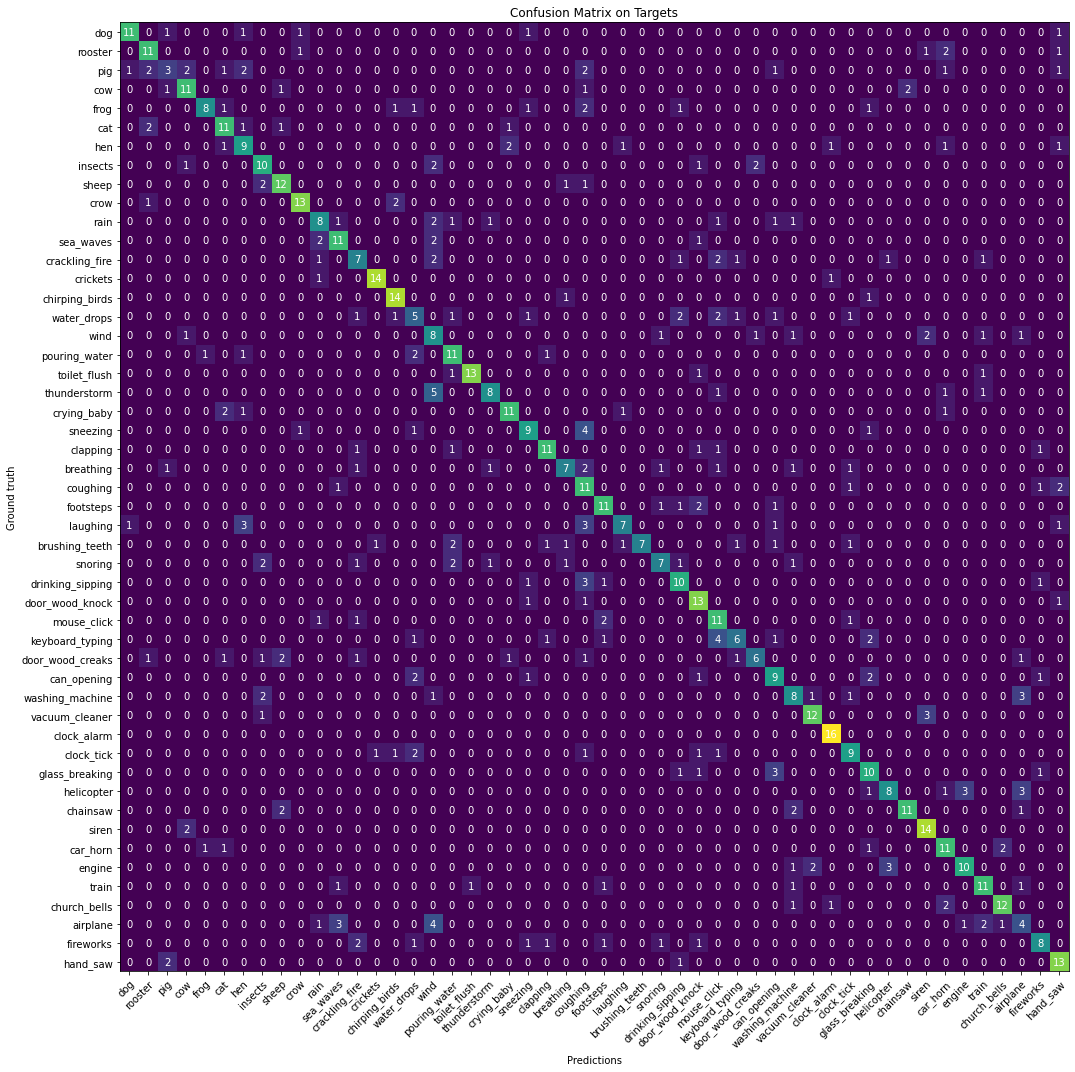

In [ ]:
targ_confusion = confusion_matrix(y_pred=targ_pred, y_true=targ_true)
plot_confusion_matrix(targ_confusion, targ_labels, "Confusion Matrix on Targets", figsize=(15, 15))

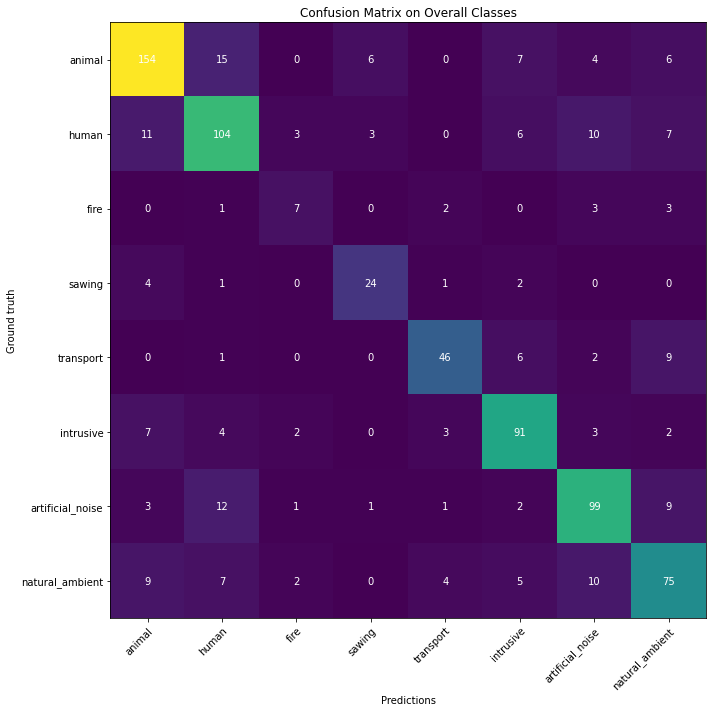

In [ ]:
class_confusion = confusion_matrix(y_pred=class_pred, y_true=class_true)
plot_confusion_matrix(class_confusion, class_labels, "Confusion Matrix on Overall Classes")

## Porting the Model

### Final Layer

In [ ]:
one_embedding_shape = embeddings[0].shape
embedding_dtype = embeddings[0].dtype

In [ ]:
@tf.function
def run_model(x):
    # Here we are assuming that `x` is the (10, 1024)-dimensional output
    # from YAMNet; so we have to expand_dims to get a batch size of 1
    x = tf.expand_dims(x, axis=0)
    logits = my_model(x)
    cat = tf.argmax(logits, axis=-1)
    return logits, cat

STEPS = one_embedding_shape[0]
INPUT_SIZE = one_embedding_shape[1]
concrete_func = run_model.get_concrete_function(
    tf.TensorSpec([STEPS, INPUT_SIZE], embedding_dtype))

# model directory.
MODEL_DIR = "keras_lstm"
my_model.save(MODEL_DIR, save_format="tf", signatures=concrete_func)

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_DIR)

# Quantisation to reduce model size without sacrificing prediction quality
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]

# Convert
tflite_model = converter.convert()

In [ ]:
with open('toplayer.tflite', 'wb') as f:
  f.write(tflite_model)

In [ ]:
!du -sh toplayer.tflite

1.2M	toplayer.tflite


### Testing tflite model

In [ ]:
class TFLiteToplayer():
    def __init__(self, path_to_toplayer):
        self.interpreter = tf.lite.Interpreter(path_to_toplayer)
        self.input_details = self.interpreter.get_input_details()
        self.embeddings_input_index = self.input_details[0]["index"]

        self.output_details = self.interpreter.get_output_details()
        self.cats_output_index = self.output_details[0]["index"]
        self.logits_output_index = self.output_details[1]["index"]
    
    def __call__(self, embeddings):
        self.interpreter.allocate_tensors()
        self.interpreter.set_tensor(self.embeddings_input_index, embeddings)
        self.interpreter.invoke()

        cats = self.interpreter.get_tensor(self.cats_output_index)
        logits = self.interpreter.get_tensor(self.logits_output_index)
        self.interpreter.reset_all_variables()
        return cats, logits

In [ ]:
toplayer = TFLiteToplayer("toplayer.tflite")

In [ ]:
num_tests = 20
test_cases = []

val_cases = val_ds.unbatch()

for x, y in val_cases:
    if len(test_cases) < num_tests:
        test_cases.append((x, y))

In [ ]:
for e, (x, y) in enumerate(test_cases):
    print(f"Test case {e+1}")

    keras_result = my_model.predict(tf.expand_dims(x, 0))
    keras_pred = tf.argmax(keras_result, axis=-1).numpy()[0]

    tflite_pred, tflite_result = toplayer(x)
    tflite_pred = tflite_pred[0]

    try:
        np.testing.assert_almost_equal(keras_result, tflite_result, decimal=4)
        print("Final layer output matches")
    except:
        print("\x1b[31mFinal layer output not matched\x1b[0m")
    
    print(f"Keras pred: {keras_pred}, tflite pred: {tflite_pred}; ground truth: {y.numpy()}\n")

Test case 1
Final layer output matches
Keras pred: 3, tflite pred: 3; ground truth: 2

Test case 2
Final layer output not matched
Keras pred: 2, tflite pred: 2; ground truth: 2

Test case 3
Final layer output matches
Keras pred: 43, tflite pred: 43; ground truth: 2

Test case 4
Final layer output matches
Keras pred: 1, tflite pred: 1; ground truth: 2

Test case 5
Final layer output matches
Keras pred: 0, tflite pred: 0; ground truth: 2

Test case 6
Final layer output not matched
Keras pred: 3, tflite pred: 3; ground truth: 2

Test case 7
Final layer output matches
Keras pred: 6, tflite pred: 6; ground truth: 2

Test case 8
Final layer output matches
Keras pred: 5, tflite pred: 5; ground truth: 2

Test case 9
Final layer output matches
Keras pred: 2, tflite pred: 2; ground truth: 2

Test case 10
Final layer output matches
Keras pred: 6, tflite pred: 6; ground truth: 2

Test case 11
Final layer output matches
Keras pred: 24, tflite pred: 24; ground truth: 2

Test case 12
Final layer outp

In [ ]:
# metadata .json file

yamnet_labels = []
mark = 0
with open(r'yamnet_labels.csv', 'r') as file:
    reader = csv.reader(file)
    for row in reader:
        if not mark:
            mark = 1
            continue
        yamnet_labels.append(row[2])

In [ ]:
IDX2CAT = {int(i):c for i, c in targcat_pairs}

with open('metadata.json', 'w') as f:
    obj = {
        "idx-cat": IDX2CAT,
        "cat-class": CAT2CLASS,
        "categories": [IDX2CAT[i] for i in range(len(IDX2CAT))],
        "classes": CLASSES,
        "yamnet-labels": yamnet_labels
    }
    json.dump(obj, f, indent=4, sort_keys=True)